C:\Users\HP\AppData\Local\Temp\ipykernel_1748\1858123625.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download("GC=F", start="2015-01-01", end="2025-09-11")
[*********************100%***********************]  1 of 1 completed

MSE: 793.5248432621622
R² Score: 0.9968800749864615


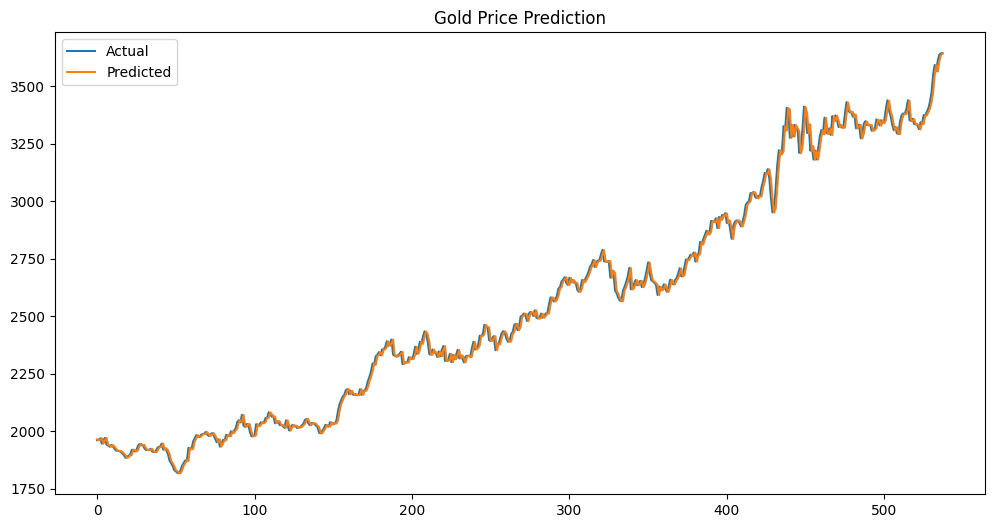

DatePicker(value=datetime.date(2024, 1, 1), description='Pick a date', max=datetime.date(2025, 9, 11), min=dat…

Output()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Download gold price data (last 10 years)
# -----------------------------
gold_data = yf.download("GC=F", start="2015-01-01", end="2025-09-11")

# Keep only closing price
df = gold_data[['Close']].copy()
df = df.dropna()

# Create shifted column for supervised learning
df['Target'] = df['Close'].shift(-1)
df = df.dropna()

# Train-Test Split
X = df[['Close']]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Gold Price Prediction")
plt.show()

# -----------------------------
# Date picker for user input
# -----------------------------
date_picker = widgets.DatePicker(
    description='Pick a date',
    disabled=False,
    value=pd.to_datetime("2024-01-01").date(),
    min=pd.to_datetime("2015-01-01").date(),
    max=pd.to_datetime("2025-09-11").date()
)
display(date_picker)

# Output widget to avoid clutter
output = widgets.Output()
display(output)

# -----------------------------
# Single prediction function
# -----------------------------
def predict_price(change):
    with output:
        clear_output()  # Clear previous output

        try:
            # Convert datetime.date to pd.Timestamp
            date_input = pd.Timestamp(date_picker.value)

            # Pick closest previous trading day if needed
            valid_dates = df.index[df.index <= date_input]
            if len(valid_dates) == 0:
                closest_date = df.index[-1]  # fallback
            else:
                closest_date = valid_dates[-1]

            # Extract scalar value safely
            selected_price = float(df.loc[closest_date, 'Close'].iloc[0])
            future_price = model.predict(np.array([[selected_price]]))

            print(f"Using date: {closest_date.date()}")
            print(f"Closing Price: {selected_price:.2f} USD")
            print(f"Predicted next day gold price: {future_price[0]:.2f} USD")

        except Exception as e:
            print("Error:", e)

# Link the picker to the prediction function
date_picker.observe(predict_price, names='value')
